## Imports

In [11]:
from pathlib import Path
import re
import json
import hashlib
import numpy as np
import pandas as pd
from urllib.parse import urlparse

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import accuracy_score

## Setup

In [2]:
PROJECT_ROOT = Path(".")
DATASETS_ROOT = Path("../dataset-creation")

PATHS = {
    "afp": DATASETS_ROOT / "AFP" / "out_afp_verificat" / "afp_verificat_dataset.csv",
    "factual": DATASETS_ROOT / "Factual" / "data" / "factual_ro_dataset_postprocessed.csv",
    "veridica": DATASETS_ROOT / "Veridica" / "data_veridica" / "veridica_dataset.csv",
    "ocr": DATASETS_ROOT / "Pseudo-FakeRom" / "ocr_fake_news_dataset.csv",
    "tnr": DATASETS_ROOT / "TNR" / "tnr_satire_dataset.csv",
}

for k, p in PATHS.items():
    print(f"{k:8s} -> exists={p.exists()}  path={p}")


afp      -> exists=True  path=..\dataset-creation\AFP\out_afp_verificat\afp_verificat_dataset.csv
factual  -> exists=True  path=..\dataset-creation\Factual\data\factual_ro_dataset_postprocessed.csv
veridica -> exists=True  path=..\dataset-creation\Veridica\data_veridica\veridica_dataset.csv
ocr      -> exists=True  path=..\dataset-creation\Pseudo-FakeRom\ocr_fake_news_dataset.csv
tnr      -> exists=False  path=..\dataset-creation\TNR\tnr_satire_dataset.csv


## Utils

In [3]:
def normalize_ws(s: str) -> str:
    return " ".join((s or "").split())

def normalize_label(s: str) -> str:
    return normalize_ws(s).upper()

def md5(s: str) -> str:
    return hashlib.md5((s or "").encode("utf-8")).hexdigest()

def safe_str(x) -> str:
    return "" if x is None or (isinstance(x, float) and np.isnan(x)) else str(x)

def get_domain(u: str) -> str:
    u = safe_str(u).strip()
    if not u:
        return ""
    try:
        d = urlparse(u).netloc.lower()
        return d.replace("www.", "")
    except Exception:
        return ""

TRUE_SET_RO = {"ADEVĂRAT", "ADEVARAT", "PARȚIAL ADEVĂRAT", "PARTIAL ADEVARAT", "PARTIAL ADEVĂRAT"}
FALSE_SET_RO = {
    "FALS", "TRUNCHIAT", "INȘELĂTOR", "INSELATOR", "CONTEXT LIPSĂ", "CONTEXT LIPSA",
    "LIPSA CONTEXTULUI", "FOTOGRAFIE ALTERATĂ", "FOTOGRAFIE ALTERATA",
    "VIDEOCLIP ALTERAT", "VIDEO ALTERAT", "DEEPFAKE", "SATIRĂ", "SATIRA", "FARSĂ", "FARSA"
}
UNVERIFIABLE_SET_RO = {"IMPOSIBIL DE VERIFICAT", "S-A RĂZGÂNDIT", "S-A RAZGANDIT"}

def map_label_binary(label_fine: str):
    L = normalize_label(label_fine)
    if L in TRUE_SET_RO:
        return 1
    if L in FALSE_SET_RO:
        return 0
    if L in UNVERIFIABLE_SET_RO:
        return None
    if L in {"REAL", "TRUE"}:
        return 1
    if L in {"FAKE", "FALSE", "FABRICATED", "PROPAGANDA", "SATIRE", "FAKE NEWS", "DEZINFORMARE"}:
        return 0
    return None

def load_afp(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "afp"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = df.get("source_url", "")
    out["source_domain"] = out["source_url"].fillna("").apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label_norm", df.get("label", "")).fillna("").apply(safe_str)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["text_long"] = ""  # not present
    out["y"] = out["label_fine"].apply(map_label_binary)
    return out

def load_factual(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "factual"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = df.get("source", df.get("speaker_url", "")).fillna("").apply(safe_str)
    out["source_domain"] = out["source_url"].apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["y"] = out["label_fine"].apply(map_label_binary)
    return out

def load_veridica(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "veridica"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = ""
    out["source_domain"] = out["url"].fillna("").apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["y"] = 0
    return out

def load_ocr(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "ocr"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = ""
    out["source_url"] = ""
    out["source_domain"] = ""
    out["title"] = ""
    out["claim"] = ""
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = ""
    if "label_group" in df.columns:
        lg = df["label_group"].fillna("").apply(safe_str).str.upper()
        out["y"] = lg.map({"REAL": 1, "TRUE": 1, "FAKE": 0, "FALSE": 0})
    else:
        out["y"] = out["label_fine"].apply(map_label_binary)
    return out

def load_tnr(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")

    out = pd.DataFrame()
    out["dataset"] = "tnr"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "").fillna("").apply(safe_str)
    out["source_url"] = out["url"]
    out["source_domain"] = out["url"].apply(get_domain)

    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = ""
    out["label_fine"] = df.get("label", "SATIRE").fillna("").apply(safe_str)

    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)

    out["text_short"] = out["title"].fillna("").apply(normalize_ws)

    out["y"] = out["label_fine"].apply(map_label_binary)

    out["section"] = df.get("section", "").fillna("").apply(safe_str)

    return out

## Create dataset

In [4]:
dfs = []
if PATHS["afp"].exists(): dfs.append(load_afp(PATHS["afp"]))
if PATHS["factual"].exists(): dfs.append(load_factual(PATHS["factual"]))
if PATHS["veridica"].exists(): dfs.append(load_veridica(PATHS["veridica"]))
if PATHS["ocr"].exists(): dfs.append(load_ocr(PATHS["ocr"]))
if PATHS.get("tnr") and PATHS["tnr"].exists(): dfs.append(load_tnr(PATHS["tnr"]))

data = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
print("Unified rows:", len(data))
display(data["dataset"].value_counts(dropna=False))
display(data.head(3))

Unified rows: 2095


dataset
NaN    2095
Name: count, dtype: int64

,dataset,id,url,source_url,source_domain,title,claim,label_fine,text_short,text_long,y
0,NaN,ec5256cca1a28dddab1e6bcea06d7698042da8cb,https://verificat.afp.com/doc.afp.com.32AD84J,https://www.facebook.com/mariana.muntean/posts...,facebook.com,Această înregistrare video nu este o dovadă că...,Acest videoclip arată că aterizarea pe Lună a ...,CONTEXT LIPSĂ,Această înregistrare video nu este o dovadă că...,,0.0
1,NaN,4010817634d8d58df5de9d932abace7d2a8ec2f5,https://verificat.afp.com/doc.afp.com.32BY897,https://www.facebook.com/Lupul.Dacic.blog/post...,facebook.com,Focarele de variola maimuței nu sunt legate de...,Variola maimuței este provocată de vaccinul As...,CONTEXT LIPSĂ,Focarele de variola maimuței nu sunt legate de...,,0.0
2,NaN,d11422ae41ff6c23d485c27ccc49b8b1a8e55d88,https://verificat.afp.com/doc.afp.com.32CX3EH,https://www.facebook.com/permalink.php?story_f...,facebook.com,Videoclipul care arată o „păpușă Ken însărcina...,"Aceasta este o nouă păpușă Ken, care este însă...",SATIRĂ,Videoclipul care arată o „păpușă Ken însărcina...,,0.0


## Build text_input

In [5]:
if len(data) == 0:
    raise RuntimeError("No data loaded. Check PATHS and DATASETS_ROOT.")

data["text_long"] = data["text_long"].fillna("").astype(str)
data["text_short"] = data["text_short"].fillna("").astype(str)

def choose_input(row) -> str:
    tl = row["text_long"]
    ts = row["text_short"]
    if isinstance(tl, str) and len(tl) >= 200:
        header = ts.strip()
        if header:
            return f"[SHORT] {header}\n[LONG] {tl}".strip()
        return tl.strip()
    return ts.strip()

data["text_input"] = data.apply(choose_input, axis=1)
data["text_len"] = data["text_input"].fillna("").apply(len)

display(data[["dataset","label_fine","text_len"]].head(10))

,dataset,label_fine,text_len
0,NaN,CONTEXT LIPSĂ,196
1,NaN,CONTEXT LIPSĂ,159
2,NaN,SATIRĂ,122
3,NaN,ÎNȘELĂTOR,185
4,NaN,CONTEXT LIPSĂ,148
5,NaN,ÎNȘELĂTOR,153
6,NaN,PARȚIAL FALS,237
7,NaN,FALS,282
8,NaN,FALS,200
9,NaN,ÎNȘELĂTOR,227


## Map to final classes

In [6]:
FINE6 = ["TRUE","PARTIAL_TRUE","FALSE","MISLEADING","PROPAGANDA","SATIRE"]
fine6_to_id = {c:i for i,c in enumerate(FINE6)}

def map_label_fine6(label_fine: str) -> str:
    L = normalize_label(label_fine)

    # SATIRE (TNR)
    if L in {"SATIRE", "SATIRĂ", "SATIRA", "FARSĂ", "FARSA"}:
        return "SATIRE"

    # PROPAGANDA
    if "PROPAG" in L:
        return "PROPAGANDA"

    # TRUE-ish
    if L in {"ADEVĂRAT", "ADEVARAT", "REAL", "TRUE"}:
        return "TRUE"
    if L in {"PARȚIAL ADEVĂRAT", "PARTIAL ADEVARAT", "PARTIAL ADEVĂRAT"}:
        return "PARTIAL_TRUE"

    # MISLEADING / context
    if L in {"TRUNCHIAT", "ÎNȘELĂTOR", "INȘELĂTOR", "INSELATOR", "CONTEXT LIPSĂ", "CONTEXT LIPSA",
             "IMPOSIBIL DE VERIFICAT", "S-A RĂZGÂNDIT", "S-A RAZGANDIT", "PLAUSIBLE"}:
        return "MISLEADING"

    # FALSE-ish
    if L in {"FALS", "FALSE", "FAKE", "FAKE NEWS", "DEZINFORMARE", "FABRICATED"}:
        return "FALSE"

    return "OTHER"

data["fine6"] = data["label_fine"].fillna("").apply(map_label_fine6)
data["fine6_id"] = data["fine6"].map(fine6_to_id)

print("Fine6 distribution:")
display(data["fine6"].value_counts(dropna=False))

Fine6 distribution:


fine6
FALSE           991
PROPAGANDA      466
TRUE            330
SATIRE          132
MISLEADING      124
OTHER            33
PARTIAL_TRUE     19
Name: count, dtype: int64

## Filter + de-duplicate

In [7]:
df6 = data[data["fine6_id"].notna()].copy()
df6["fine6_id"] = df6["fine6_id"].astype(int)
df6 = df6[df6["text_len"] >= 30].copy()

df6["text_hash"] = df6["text_input"].apply(lambda s: md5(normalize_ws(str(s).lower())[:2000]))

print("Training rows (fine6):", len(df6))
display(df6[["fine6","dataset","text_len"]].value_counts().head(30))

Training rows (fine6): 2062


Series([], Name: count, dtype: int64)

In [8]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss1.split(df6, groups=df6["text_hash"]))
train = df6.iloc[train_idx].copy()
test = df6.iloc[test_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss2.split(train, groups=train["text_hash"]))
train2 = train.iloc[tr_idx].copy()
val = train.iloc[val_idx].copy()

def show_dist(name, df):
    print(name, "rows:", len(df))
    display(df["fine6"].value_counts())

show_dist("Train", train2)
show_dist("Val", val)
show_dist("Test", test)

Train rows: 1318


fine6
FALSE           637
PROPAGANDA      294
TRUE            219
SATIRE           88
MISLEADING       69
PARTIAL_TRUE     11
Name: count, dtype: int64

Val rows: 331


fine6
FALSE           163
PROPAGANDA       81
TRUE             48
MISLEADING       20
SATIRE           17
PARTIAL_TRUE      2
Name: count, dtype: int64

Test rows: 413


fine6
FALSE           191
PROPAGANDA       91
TRUE             63
MISLEADING       35
SATIRE           27
PARTIAL_TRUE      6
Name: count, dtype: int64

## Train transformer

In [9]:
MODEL_NAME = "readerbench/RoBERT-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(FINE6),
    id2label={i:c for i,c in enumerate(FINE6)},
    label2id={c:i for i,c in enumerate(FINE6)},
)
model.config.problem_type = "single_label_classification"

def make_hf_dataset(df: pd.DataFrame) -> Dataset:
    d = df[["text_input","fine6_id"]].copy()
    d["fine6_id"] = d["fine6_id"].astype(int)
    return Dataset.from_pandas(d.rename(columns={"text_input":"text","fine6_id":"label"}), preserve_index=False)

train_ds = make_hf_dataset(train2)
val_ds = make_hf_dataset(val)
test_ds = make_hf_dataset(test)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

collator = DataCollatorWithPadding(tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

In [10]:
counts = train2["fine6_id"].value_counts().sort_index()
freq = counts.reindex(range(len(FINE6)), fill_value=0).values.astype(np.float32)

freq = np.maximum(freq, 1.0)
weights = freq.sum() / freq
weights = weights / weights.mean()  # normalize

class_weights = torch.tensor(weights, dtype=torch.float32)
print("Class weights:", {FINE6[i]: float(class_weights[i]) for i in range(len(FINE6))})

Class weights: {'TRUE': 0.21691709756851196, 'PARTIAL_TRUE': 4.31862211227417, 'FALSE': 0.07457588613033295, 'MISLEADING': 0.688476026058197, 'PROPAGANDA': 0.1615810990333557, 'SATIRE': 0.5398277640342712}


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

class WeightedTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./fine6_roberta",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=100,
    report_to="none",
)

trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\alex_\.conda\envs\test_env\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.181900,0.422524,0.861027,0.767929,0.849909
2,0.450400,0.301089,0.906344,0.855386,0.897133
3,0.429800,0.301642,0.897281,0.842824,0.888523
4,0.220400,0.286135,0.918429,0.874069,0.911054


TrainOutput(global_step=660, training_loss=0.5199169187834769, metrics={'train_runtime': 841.5299, 'train_samples_per_second': 6.265, 'train_steps_per_second': 0.784, 'total_flos': 1387171301474304.0, 'train_loss': 0.5199169187834769, 'epoch': 4.0})

## Evaluate on test

In [13]:
print("VAL metrics:")
print(trainer.evaluate(val_ds))

print("\nTEST metrics:")
print(trainer.evaluate(test_ds))

VAL metrics:


{'eval_loss': 0.28613489866256714, 'eval_accuracy': 0.918429003021148, 'eval_f1_macro': 0.8740693633930204, 'eval_f1_weighted': 0.9110540332852617, 'eval_runtime': 16.7071, 'eval_samples_per_second': 19.812, 'eval_steps_per_second': 2.514, 'epoch': 4.0}

TEST metrics:
{'eval_loss': 0.3948576748371124, 'eval_accuracy': 0.87409200968523, 'eval_f1_macro': 0.8205421018475655, 'eval_f1_weighted': 0.8536830140820232, 'eval_runtime': 20.4658, 'eval_samples_per_second': 20.18, 'eval_steps_per_second': 2.541, 'epoch': 4.0}


              precision    recall  f1-score   support

        TRUE       0.77      1.00      0.87        63
PARTIAL_TRUE       1.00      1.00      1.00         6
       FALSE       0.92      0.92      0.92       191
  MISLEADING       1.00      0.17      0.29        35
  PROPAGANDA       0.84      0.92      0.88        91
      SATIRE       0.96      0.96      0.96        27

    accuracy                           0.87       413
   macro avg       0.91      0.83      0.82       413
weighted avg       0.89      0.87      0.85       413



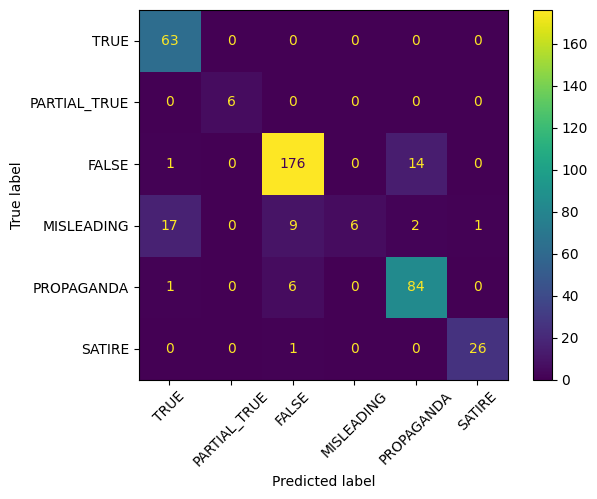

In [14]:
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=1)

print(classification_report(y_true, y_pred, target_names=FINE6))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=FINE6).plot(xticks_rotation=45)
plt.show()

## Save model in splits

In [15]:
OUT_DATA = PROJECT_ROOT / "UnifiedFineGrained"
OUT_MODELS = PROJECT_ROOT / "models"
OUT_DATA.mkdir(exist_ok=True)
OUT_MODELS.mkdir(exist_ok=True)

train2.to_csv(OUT_DATA / "train_fine6.csv", index=False, encoding="utf-8")
val.to_csv(OUT_DATA / "val_fine6.csv", index=False, encoding="utf-8")
test.to_csv(OUT_DATA / "test_fine6.csv", index=False, encoding="utf-8")

MODEL_DIR = OUT_MODELS / "fine6_roberta"
trainer.save_model(str(MODEL_DIR))
tokenizer.save_pretrained(str(MODEL_DIR))

meta = {
    "model_name": MODEL_NAME,
    "classes": FINE6,
    "id2label": {str(i): c for i,c in enumerate(FINE6)},
    "label2id": {c: i for i,c in enumerate(FINE6)},
    "input_field": "text_input",
    "notes": "6-class fine-grained labels mapped from multiple datasets. Class imbalance handled via weighted CE.",
}
(MODEL_DIR / "meta.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

print("Saved splits to:", OUT_DATA)
print("Saved model to:", MODEL_DIR)

Saved splits to: UnifiedFineGrained
Saved model to: models\fine6_roberta
